# Regime-Switching Models: A Guide to Hidden Markov Models

This notebook serves as guide to understanding and training **Hidden Markov Models (HMM)** for financial time series analysis.

We adopt a **frequentist approach** to parameter estimation, using the *Expectation-Maximization (EM)* algorithm to find maximum likelihood estimates. This contrasts with Bayesian approaches that would specify prior distributions and compute full posterior densities.

Instead of assuming that the history of an asset is described by a single set of parameters, HMMs' core idea is that the market switches between unobserved "hidden" states (or *regimes*), such as:

*   **Bull Markets**: High average returns, low volatility.
*   **Bear Markets**: Negative average returns, high volatility.
*   **Sideways/Choppy Markets**: Uncertain direction, mixed volatility.

By explicitly modeling these switches and their distributions, we aim to better understand the current market environment.

## Notebook Roadmap
In this notebook, we will:
1.  **Configure & Load Data**: Prepare financial time series for modeling.
2.  **Data Analysis**: Visualize the empirical data to identify properties we need to model (e.g. fat tails).
3.  **Train a GMM-HMM**: Fit a Gaussian Mixture HMM to a specific window of data.
4.  **Decode the Regimes**: Interpret the "hidden" states—what do they actually represent?
5.  **Analyze Mixtures**: Visualize how the model constructs complex distributions from simple Gaussian components.
6.  **Forecast**: Mathematically derive the "One-Step-Ahead" prediction density and compare with reality.

## 1. Configuration

We begin by setting the core parameters.

In [1]:
import stock
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GMMHMM

In [2]:
# Main Parameters
TICKER = 'F'
TIME_FREQUENCY = 'weekly'       # Options: 'daily', 'weekly'

# Model Hyperparameters
N_STATES = 3           # Number of hidden regimes (e.g., 2=Bull/Bear, 3=Bull/Neut/Bear)
N_MIXTURES = 3         # Number of Gaussian components per state
# Covariance Structure:
# 'tied' = all mixtures in a state share same covariance (balanced). helps constraining the number of params
# 'diag' = each mixture in each state has independent variance (more flexible but risk of overfitting or numerical issues)
# 'full' = full covariance matrix per mixture (most flexible, but better suited for multivariate data)
COVARIANCE_TYPE = 'tied' 

# Training Window
# Dynamic logic: 500 weeks (~10 years) or 1500 days (~6 years)
if TIME_FREQUENCY == 'weekly':
    TRAINING_WINDOW = 500
else:
    TRAINING_WINDOW = 1500

print(f"Configuration: {TICKER} [{TIME_FREQUENCY}]")
print(f"Training Window: {TRAINING_WINDOW} periods")

Configuration: F [weekly]
Training Window: 500 periods


## 2. Data Loading & Preparation

We load the data using the `stock` class and `yfinance` library, and visualize the price history in log-scale.
Log-scale is necessary for a consistent visualization of long-term price series characterized by a strong trend component.

In [3]:
# Load Data
my_stock = stock.Stock(TICKER, TIME_FREQUENCY)
my_stock.load_data(start_date='1980-01-01')

# Extract Log Returns
stock_returns = my_stock.get_data()['Log_Returns'].dropna()
prices = my_stock.get_data()['Close']

print(f"Data Summary for {TICKER}:")
print(f"  Range: {stock_returns.index[0].date()} to {stock_returns.index[-1].date()}")
print(f"  Total Observations: {len(stock_returns)}")

From F dataset were removed 72 rows with missing or incorrect data
Ticker: F has 5 anomalies:
  Open-pClose Anomalies: 1
  High-Low Anomalies: 3
  Close-Open Anomalies: 1

Weekly data loaded from 1980-01-04 to 2026-01-23
Total weeks loaded: 2404
Data Summary for F:
  Range: 1980-01-11 to 2026-01-23
  Total Observations: 2403


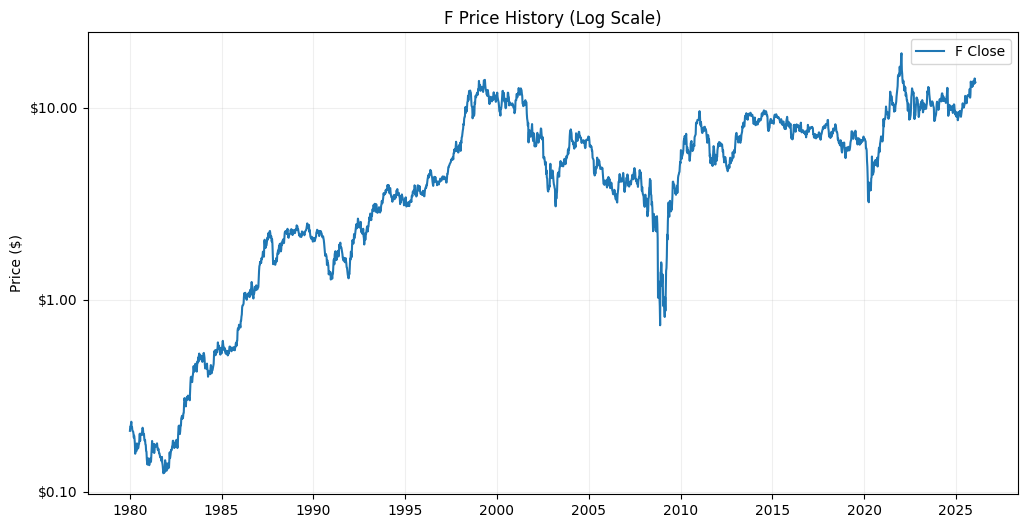

In [4]:
# Visualize Price History
plt.figure(figsize=(12, 6))
plt.semilogy(prices.index, prices.values, label=f'{TICKER} Close')
plt.title(f"{TICKER} Price History (Log Scale)")
plt.ylabel("Price ($)")
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:.2f}'))
ax.minorticks_off()  # Remove minor tick marks
plt.grid(True, which="major", ls="-", alpha=0.2)
plt.legend()
plt.show()

### Empirical Distribution Analysis

Here we visually examine the distribution of log-returns. The red line represents a standard Normal distribution fitted to the data.
Note the discrepancies: the empirical data has generally a higher peak and much wider "tails" (extreme values) than the Normal curve predicts.
This motivates using a **Mixture Model** (combination of Gaussians) rather than a simple Gaussian distribution.

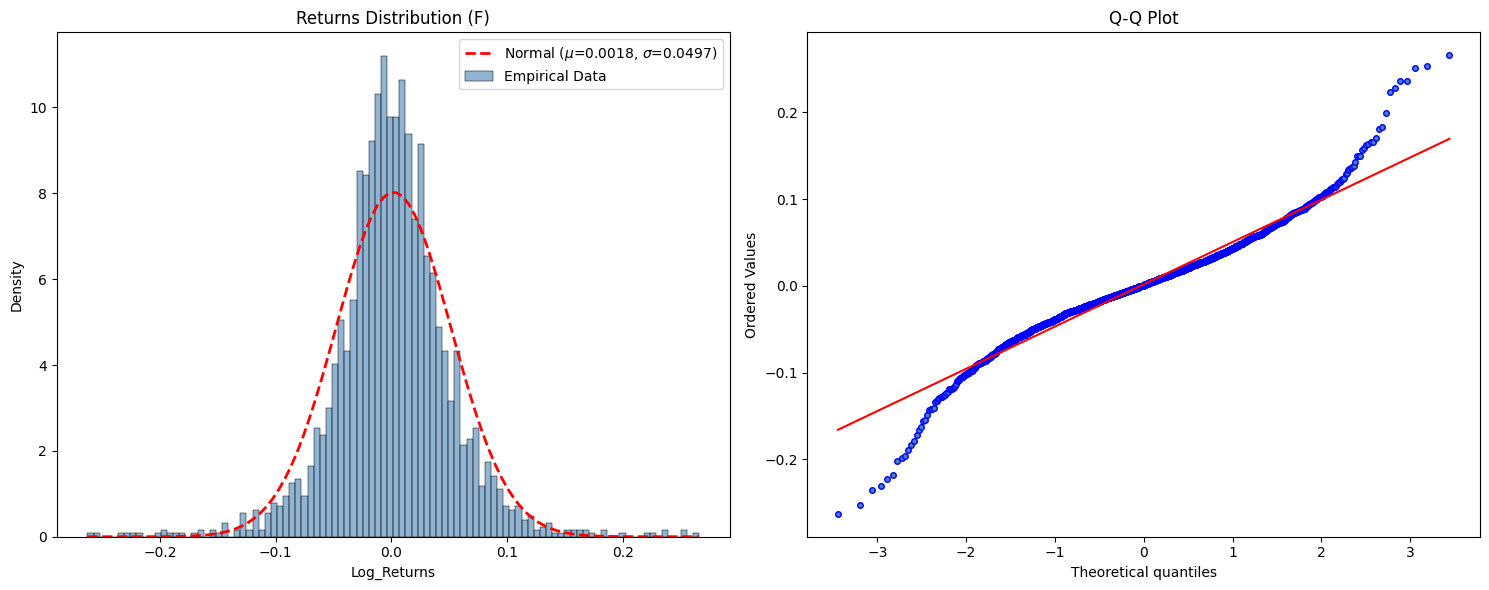

In [5]:
def remove_outliers(data: pd.Series, multiplier: int = 4):
    """
    Filter out extreme outliers for cleaner visualization (using IQR method).
    This helps in seeing the main body of the distribution without the graph being distorted by 1-2 extreme crashes.
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - multiplier * IQR) & (data <= Q3 + multiplier * IQR)]

# Filter the returns from outliers ONLY for a better visualization
filtered_returns = remove_outliers(stock_returns, multiplier=5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram vs Normal
sns.histplot(filtered_returns, bins=100, stat='density', alpha=0.6, color='steelblue', label='Empirical Data', ax=ax1)
x_range = np.linspace(filtered_returns.min(), filtered_returns.max(), 100)
stats_mu, stats_sigma = filtered_returns.mean(), filtered_returns.std()
ax1.plot(x_range, stats.norm.pdf(x_range, stats_mu, stats_sigma), 
        'r--', lw=2, label=f'Normal ($\mu$={stats_mu:.4f}, $\sigma$={stats_sigma:.4f})')
ax1.set_title(f'Returns Distribution ({TICKER})')
ax1.legend()

# Q-Q Plot
# Deviations from the red line indicate non-normality (fat tails)
stats.probplot(filtered_returns, dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('steelblue')
ax2.get_lines()[0].set_markersize(4)
ax2.set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

## 3. Training the Model

First we select a specific date of interest to train the model up to. We can think of this as the "today" date for our analysis.
We select a set of prior data (the training window) to fit the model.
We will standardize the returns to have mean 0 and variance 1, which helps convergence of the EM algorithm.

In [6]:
def find_nearest_date(index: pd.DatetimeIndex, target_date_str: str):
    """
    Finds the index location of the nearest available date in the index.
    """
    target = pd.Timestamp(target_date_str)
    if index.tz is not None and target.tz is None:
        target = target.tz_localize(index.tz)
    
    # Calculate absolute difference
    diffs = np.abs(index - target)
    # Find index of minimum difference
    idx_loc = diffs.argmin()
    nearest_date = index[idx_loc]
    
    print(f"Target Date: {target.date()} -> Nearest found: {nearest_date.date()}")
    return idx_loc

# "Today" date for training (choose as you wish) - YYYY-MM-DD
TARGET_DATE = '2020-02-01'

# Determine the training interval
train_end_idx = find_nearest_date(stock_returns.index, TARGET_DATE)
train_start_idx = train_end_idx - TRAINING_WINDOW

# Safety check for sufficient data
if train_start_idx < 0:
    raise ValueError(f"Not enough data history. Change TARGET_DATE or reduce TRAINING_WINDOW.")

# Prepare Training Data
# The HMM expects a 2D array (N_samples, N_features)
# NB: iloc[start:end] is exclusive of 'end', so train_end_idx is the first out-of-sample observation
train_returns_raw = stock_returns.iloc[train_start_idx:train_end_idx].values.reshape(-1, 1)

# Standardization
# HMM algorithms converge faster and more reliably on standardized data (mean 0, var 1).
scaler = StandardScaler()
train_returns = scaler.fit_transform(train_returns_raw)

print(f"\nTraining Data Interval:")
print(f"  Start: {stock_returns.index[train_start_idx].date()}")
print(f"  End:   {stock_returns.index[train_end_idx-1].date()}")
print(f"  Observations: {len(train_returns)}")
print(f"  Next OOS Date: {stock_returns.index[train_end_idx].date()}")

Target Date: 2020-02-01 -> Nearest found: 2020-01-31

Training Data Interval:
  Start: 2010-07-02
  End:   2020-01-24
  Observations: 500
  Next OOS Date: 2020-01-31


### Fitting the GMM-HMM

We initialize and fit the `GMMHMM` using the **Expectation-Maximization (EM)** algorithm.

**Theoretical Foundation:**

The GMM-HMM assumes:
1. **Hidden States**: The market operates in one of $K$ unobserved regimes at each time $t$.
2. **Markov Property**: State transitions follow a first-order Markov chain: $P(S_t | S_{t-1}, S_{t-2}, ...) = P(S_t | S_{t-1})$.
3. **Emission Distributions**: Within each state $k$, returns are drawn from a Gaussian Mixture Model with $M$ components:
   $$p(r_t | S_t=k) = \sum_{m=1}^{M} w_{k,m} \mathcal{N}(r_t | \mu_{k,m}, \sigma_{k,m}^2)$$

**Why Mixtures?** Financial returns exhibit fat tails and skewness that single Gaussians cannot capture (we just visually confirmed this). 
By combining multiple Gaussians per state, we can approximate complex, non-normal distributions while maintaining tractability.
This capability is ensured by the **Universal Approximation Theorem for Gaussian Mixtures**: any continuous probability density
can be approximated arbitrarily well by a finite mixture of Gaussians, provided enough components are used.
This theoretical guarantee justifies our modeling choice.

**The EM Algorithm** (Dempster, Laird, & Rubin, 1977) iteratively maximizes the likelihood in the presence of latent variables:
- **E-Step**: Compute posterior probabilities $P(S_t | r_{1:T})$ given current parameters (forward-backward algorithm).
- **M-Step**: Update parameters (transition matrix, means, covariances, weights) to maximize expected complete-data log-likelihood.

This continues until convergence (log-likelihood improvement < tolerance).

*Reference: Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977). Maximum likelihood from incomplete data via the EM algorithm. Journal of the Royal Statistical Society: Series B, 39(1), 1-38.*


In [7]:
model = GMMHMM(
    n_components=N_STATES, 
    n_mix=N_MIXTURES,
    covariance_type=COVARIANCE_TYPE,
    n_iter=1000,              # Max iterations for EM algorithm
    random_state=42,          # Reproducibility
    tol=1e-4,                 # Convergence threshold for log-likelihood improvement
    min_covar=1e-4,           # Floor for covariance to prevent numerical issues
    init_params='stmcw'       # Initialize randomly: startprob, transmat, means, covars, weights
)

print(f"Fitting GMM-HMM...")
print(f"  States: {N_STATES}")
print(f"  Mixtures per State: {N_MIXTURES}")
model.fit(train_returns)

monitor = model.monitor_
print(f"\nModel Fit Status:")
print(f"  Converged: {monitor.converged}")
print(f"  Iterations: {monitor.iter}")
print(f"  Log Likelihood: {monitor.history[-1]:.2f}")

Fitting GMM-HMM...
  States: 3
  Mixtures per State: 3

Model Fit Status:
  Converged: True
  Iterations: 605
  Log Likelihood: -689.47


## 4. Deep Dive: Interpreting the Regimes

After training the HMM, we want to interpret what each hidden state represents economically.

### Theoretical Foundation: Law of Total Moments

Each state is a **Gaussian Mixture**, not a single Gaussian. To characterize it, we aggregate statistics across $M$ mixture components:

**Mean (First Raw Moment):**
$$\mu_{state} = \sum_{m=1}^{M} w_m \mu_m$$

**Variance (Law of Total Variance):**

The general **Law of Total Variance** states: 
$$\text{Var}(X) = E[\text{Var}(X|Y)] + \text{Var}(E[X|Y])$$

For a mixture with component indicator $Y$ (which component generated observation $X$), this becomes:
$$\sigma^2_{state} = \sum_{m=1}^{M} w_m \sigma_m^2 + \sum_{m=1}^{M} w_m \mu_m^2 - \mu_{state}^2$$

Which can be rewritten as:
$$\sigma^2_{state} = \sum_{m=1}^{M} w_m(\sigma_m^2 + \mu_m^2) - \mu_{state}^2$$

**Higher Moments (Skewness & Kurtosis):**
These require combining the non-central moments of each component relative to the aggregate mean:
- **Skewness** quantifies asymmetry (fat left vs right tail)
- **Kurtosis** measures tail heaviness (fat tails indicate extreme events)

**Expected Duration:**
For regime $i$, given the persistence probability $T_{ii}$ (the diagonal element of the transition matrix),
the expected duration before switching to another regime follows a geometric distribution:
$$\text{Duration}_i = \frac{1}{1 - T_{ii}}$$
For example, if $T_{ii} = 0.95$, the expected duration is $1/(1-0.95) = 20$ periods.

These aggregated statistics allow us to label regimes (e.g., "Bull", "Bear", "Volatile") based on their expected return, volatility, and tail properties.

In [8]:
def undo_standardize(value, scaler):
    """Helper to convert standardized values back to real log-returns."""
    return value * scaler.scale_[0] + scaler.mean_[0]

def extract_state_stats_full(model, state_idx, scaler):
    """
    Calculates aggregated moments (Mean, Var, Skew, Kurt) for a GMM state.
    
    Mathematical details:
    - Mean: E[X] = sum(w_i * mu_i)
    - Var:  Var(X) = sum(w_i * (sigma_i^2 + mu_i^2)) - E[X]^2
    - Higher moments require combining central moments of components.
    """
    # 1. Extract raw parameters for the state
    weights = model.weights_[state_idx]
    means = model.means_[state_idx].flatten()
    
    if model.covariance_type == 'tied':
        # In tied, one covariance matrix per state
        covs = np.full(len(weights), model.covars_[state_idx][0][0])
    elif model.covariance_type == 'diag':
        covs = model.covars_[state_idx].flatten()
    else:
        # Full or otherwise
        covs = model.covars_[state_idx].flatten()
        
    # 2. Aggregated Mean
    agg_mean = np.sum(weights * means)
    
    # 3. Aggregated Variance
    # Law of Total Variance
    agg_var = np.sum(weights * (covs + (means - agg_mean)**2))
    
    # 4. Higher Moments (Skewness & Kurtosis)
    # d_i = mu_i - mu_state
    d = means - agg_mean
    
    # Non-central moments relative to state mean
    # 3rd moment: sum(w * (d^3 + 3*d*var))
    m3 = np.sum(weights * (d**3 + 3 * d * covs))
    
    # 4th moment: sum(w * (d^4 + 6*d^2*var + 3*var^2))
    m4 = np.sum(weights * (d**4 + 6 * d**2 * covs + 3 * covs**2))
    
    # Standardized Skew/Kurt
    skewness = m3 / (agg_var**1.5) if agg_var > 0 else 0
    kurtosis = m4 / (agg_var**2) - 3 if agg_var > 0 else 0  # Excess Kurtosis
    
    # 5. Convert relevant stats to Real Units (for human reading)
    # Note: Skew/Kurt are dimensionless, so they don't change with scaling (mostly)
    real_mean = undo_standardize(agg_mean, scaler)
    real_std = np.sqrt(agg_var) * scaler.scale_[0]
    
    return {
        'mean': real_mean,
        'vol': real_std,
        'skew': skewness,
        'kurt': kurtosis
    }

# REGIME ANALYSIS
state_props = {}
freq_label = TIME_FREQUENCY.capitalize()

state_data = []
for s in range(N_STATES):
    stats_dict = extract_state_stats_full(model, s, scaler)
    
    # Calculate duration
    p_stay = model.transmat_[s, s]
    duration = 1 / (1 - p_stay) if p_stay < 1 else 999
    
    # Store for later sorting
    state_props[s] = stats_dict
    
    state_data.append({
        'State': s,
        f'{freq_label} Return': f"{stats_dict['mean']:+.4f}",
        f'{freq_label} Vol': f"{stats_dict['vol']:.4f}",
        'Skewness': f"{stats_dict['skew']:+.2f}",
        'Kurtosis': f"{stats_dict['kurt']:+.2f}",
        'Exp. Duration': f"{duration:.1f}"
    })

states_df = pd.DataFrame(state_data)
print("\nRegime Statistics:")
print(states_df.to_string(index=False))


Regime Statistics:
 State Weekly Return Weekly Vol Skewness Kurtosis Exp. Duration
     0       -0.0112     0.0280    -0.00    -0.00           1.0
     1       +0.0096     0.0498    -0.23    -0.09           1.6
     2       -0.0012     0.0248    -0.36    +0.42          22.4


### 4.1 The Transition Matrix: Regime Dynamics

The transition matrix $\mathbf{T}$ below is **learned from the training data** via the EM algorithm.
It encodes the probability of moving from one regime to another:

$$T_{ij} = P(S_{t+1} = j \mid S_t = i)$$

**Important:** These are the estimated population parameters (the "rules" of regime switching),
not the forecast probabilities for a specific next future period. 

**Key Properties:**
- **Diagonal elements** $T_{ii}$ represent regime persistence. High values (e.g., 0.95) indicate stable regimes that last many periods.
- **Off-diagonal elements** $T_{ij}$ ($i \neq j$) represent switching probabilities. Low values mean rare transitions.

This matrix is fundamental for forecasting: it propagates today's state belief into tomorrow's expectation.

In [9]:
trans_matrix = pd.DataFrame(
    model.transmat_,
    index=[f"From S{i}" for i in range(N_STATES)],
    columns=[f"To S{i}" for i in range(N_STATES)]
)
print("Transition Matrix:")
print(trans_matrix.round(4))

Transition Matrix:
          To S0   To S1   To S2
From S0  0.0001  0.9999  0.0000
From S1  0.5596  0.3783  0.0621
From S2  0.0438  0.0007  0.9554


### 4.3 Visualizing Mixtures

We compare the learned distributions in the different states against the histogram of the empirical data.
This allows us to understand how well or badly the mixtures are able to capture the features of the original distribution.

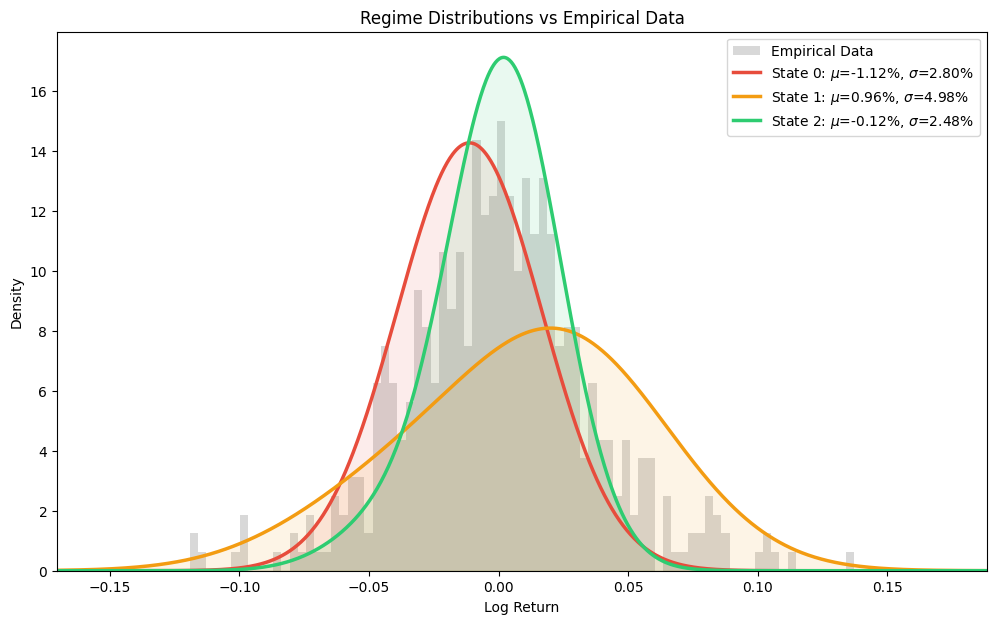

In [10]:
def get_regime_colors(n_states):
    """
    Returns a sensible color palette for regime visualization.
    Uses standard colors that work well for 2 to 4 states.
    """
    color_schemes = {
        2: ['#e74c3c', '#2ecc71'],  # Red (Bear), Green (Bull)
        3: ['#e74c3c', '#f39c12', '#2ecc71'],  # Red (Bear), Orange (Neutral), Green (Bull)
        4: ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71']  # Red, Orange, Yellow, Green
    }
    return color_schemes.get(n_states, ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:n_states])

def plot_mixture_pdfs_refined(model, scaler, train_data_raw, state_props):
    """
    Plots the PDF of each state mixture against the empirical data.
    """
    data = train_data_raw.flatten()
    # Use real data range for x-axis
    x_min, x_max = data.min(), data.max()
    padding = (x_max - x_min) * 0.2
    x = np.linspace(x_min - padding, x_max + padding, 1000)
    
    # Standardize x for model compatibility
    x_std = scaler.transform(x.reshape(-1, 1)).flatten()
    
    plt.figure(figsize=(12, 7))
    
    # 1. Background: Empirical Histogram
    plt.hist(data, bins=80, density=True, alpha=0.3, color='gray', label='Empirical Data')
    
    # 2. Foreground: State PDFs with smart colors
    colors = get_regime_colors(model.n_components)
    
    for s in range(model.n_components):
        # Calculate PDF values on standardized grid
        pdf_vals = np.zeros_like(x_std)
        
        # Sum weighted components
        for i in range(model.n_mix):
            w = model.weights_[s, i]
            mu = model.means_[s, i, 0]
            if model.covariance_type == 'tied':
                var = model.covars_[s][0][0]
            else:
                var = model.covars_[s][i]
            
            pdf_vals += w * stats.norm.pdf(x_std, mu, np.sqrt(var))
        
        # To scale PDF density back to real x space, divide by scale
        pdf_real = pdf_vals / scaler.scale_[0]
        
        # Label with stats
        mu_real = state_props[s]['mean']
        label = f"State {s}: $\mu$={mu_real:.2%}, $\sigma$={state_props[s]['vol']:.2%}"
        
        plt.plot(x, pdf_real, lw=2.5, label=label, color=colors[s])
        plt.fill_between(x, pdf_real, alpha=0.1, color=colors[s])

    plt.title("Regime Distributions vs Empirical Data")
    plt.xlabel("Log Return")
    plt.ylabel("Density")
    plt.legend()
    plt.xlim(x_min-padding, x_max+padding)
    plt.show()

plot_mixture_pdfs_refined(model, scaler, train_returns_raw, state_props)

## 5. Historical Regime Decoding

We now decode which regime the market was in at each point in the training period.

The `predict_proba()` method uses **smoothing** (Forward-Backward algorithm): for each time $t$, it computes
$P(S_t \mid X_{1:T})$ using the entire data sequence. This differs from **filtering**, which would only use
data up to $t$. Smoothing gives the best retrospective state estimates once all data is known.

### Visualization
- **Top panel**: Prices colored by most probable regime, revealing market structure over time
- **Bottom panel**: Stacked state probabilities showing classification certainty

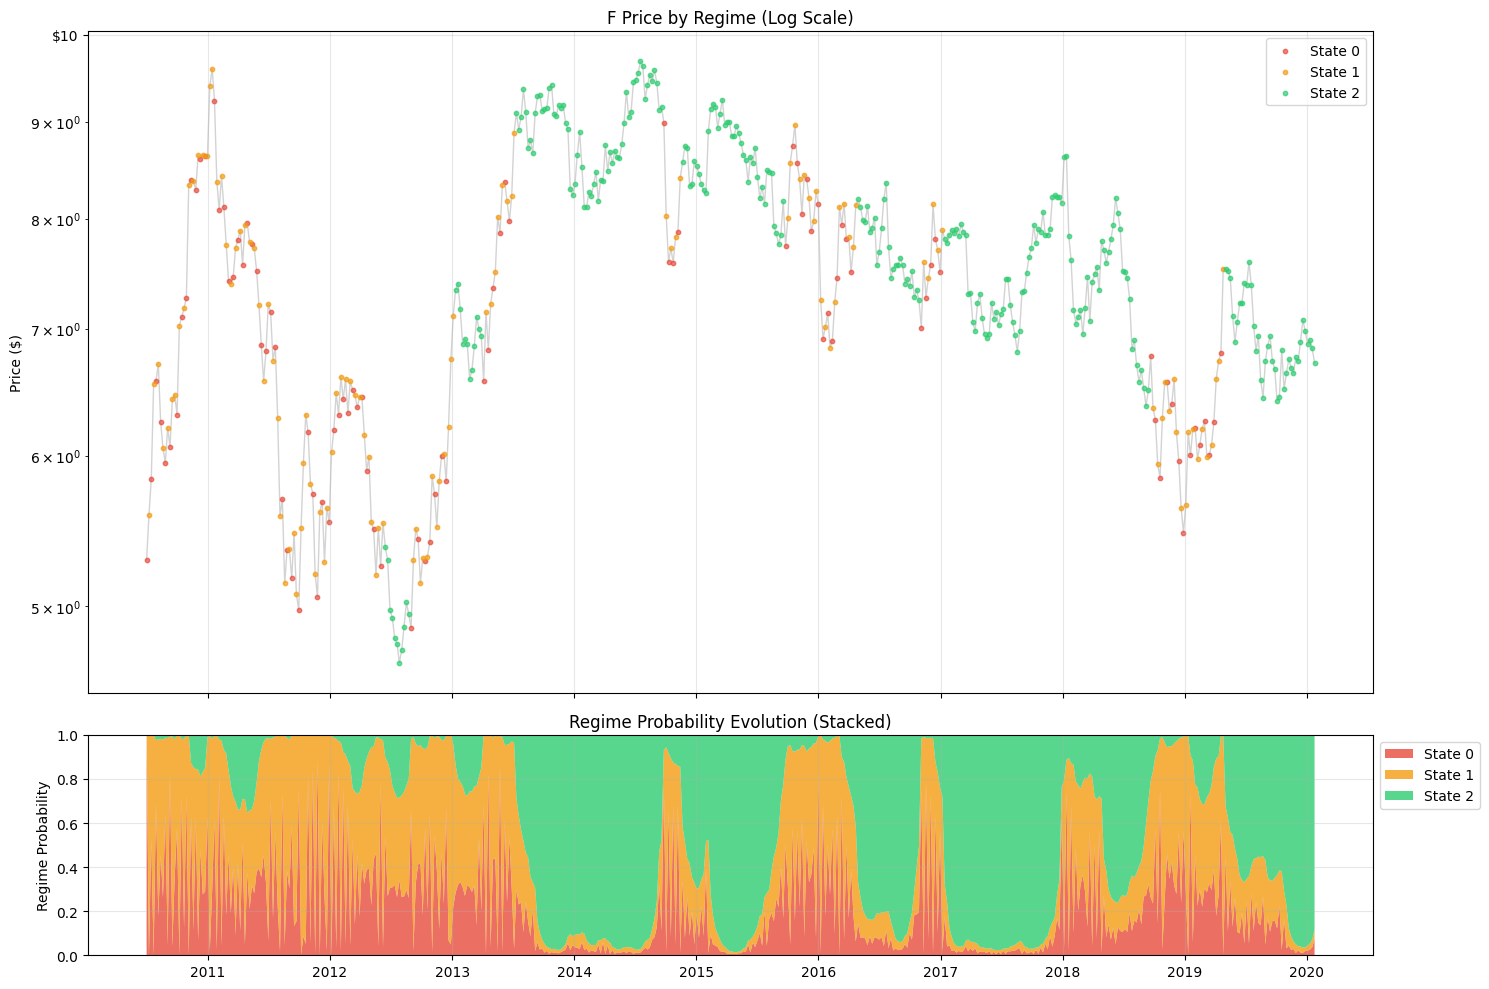

In [11]:
# Decode regime probabilities and most likely states for each historical date
# For retrospective analysis, we use smoothing which uses all available data
posterior_probs_smoothed = model.predict_proba(train_returns)
hidden_states = model.predict(train_returns)

# Prepare dataframe
dates = stock_returns.index[train_start_idx:train_end_idx]
df_plot = pd.DataFrame(index=dates)
df_plot['Price'] = prices.loc[dates]  # Regular prices, we'll use log scale for y-axis
df_plot['Regime'] = hidden_states

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Setup Colors - use consistent color scheme
colors = get_regime_colors(N_STATES)

# 1. Price Chart with Regime Coloring (Log Scale)
ax1.plot(df_plot.index, df_plot['Price'], color='lightgray', lw=1, zorder=0)

# Plot scatter points for each regime
for s in range(N_STATES):
    mask = df_plot['Regime'] == s
    ax1.scatter(df_plot.index[mask], df_plot.loc[mask, 'Price'], 
                color=colors[s], s=10, label=f'State {s}', alpha=0.7)

ax1.set_yscale('log')  # Use log scale for y-axis
ax1.set_title(f"{TICKER} Price by Regime (Log Scale)")
ax1.set_ylabel("Price ($)")
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:.0f}'))
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Stacked Area Chart for Regime Probabilities
ax2.stackplot(df_plot.index, *[posterior_probs_smoothed[:, s] for s in range(N_STATES)],
              labels=[f'State {s}' for s in range(N_STATES)],
              colors=colors, alpha=0.8)

ax2.set_ylabel("Regime Probability")
ax2.set_ylim(0, 1)
ax2.set_title("Regime Probability Evolution (Stacked)")
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Forecasting: The One-Step-Ahead Prediction

Given our belief about the current state $P(S_T \mid X_{1:T})$, we forecast the next state using the transition matrix:

$$P(S_{T+1} \mid X_{1:T}) = P(S_T \mid X_{1:T}) \cdot \mathbf{T}$$

This is a direct application of the **Chapman-Kolmogorov equation** for discrete-time Markov chains.

The forecast return distribution is a **mixture of mixtures**:

$$p(r_{T+1} \mid X_{1:T}) = \sum_{k=1}^{K} P(S_{T+1}=k \mid X_{1:T}) \cdot p(r_{T+1} \mid S_{T+1}=k)$$

From this, we compute:
- **Expected Return**: $E[r_{T+1}] = \sum_k P(S_{T+1}=k) \cdot \mu_k$
- **Predicted Volatility** (standard deviation): $\sqrt{Var[r_{T+1}]}$ via the Law of Total Variance

### Validation: Realized vs Predicted Outcomes

**Returns**: Directly comparable—we check if the actual return falls within the predicted distribution using Z-score.

**Volatility**: Not observable from a single return. We compare predicted volatility to **realized volatility** over a forward window (e.g., 5-20 periods).

**State Probabilities**: Since states are latent, we cannot observe the "true" state. However, we can validate our forecast $P(S_{T+1} \mid X_{1:T})$ by comparing it to the **ex-post smoothed probability** $P(S_{T+1} \mid X_{1:T+1})$. Without retraining the model, we extend the data by one period and run the forward-backward algorithm to obtain the smoothed belief—conditioning on all available information including the realized return at $T+1$. Close alignment between ex-ante forecast and ex-post smoothed belief suggests well-calibrated state predictions.

In [12]:
# 1. State Belief at T
# We need the state probability at the last time step T: P(S_T | X_{1:T})
# model.score_samples() returns the smoothed posterior probabilities P(S_t | X_{1:T}) for all t.
# For the very last point t=T, the smoothed probability is equivalent to the filtered probability
# because there is no future data X_{T+1:...} to condition on.
_, posterior_probs = model.score_samples(train_returns)
last_state_belief = posterior_probs[-1]

# 2. Forecast State for T+1
next_state_probs = last_state_belief @ model.transmat_

print(f"Forecast for Date: {stock_returns.index[train_end_idx].date()}")
print("-" * 40)
print(f"{'State':<6} | {'Prob(t)':<10} | {'Prob(t+1)':<10}")
for s in range(N_STATES):
    print(f"{s:<6} | {last_state_belief[s]:.4f}     | {next_state_probs[s]:.4f}")

# 3. Expected Return and Confidence Interval
expected_ret = 0
expected_var = 0

for s in range(N_STATES):
    stats_s = state_props[s]
    prob = next_state_probs[s]
    
    expected_ret += prob * stats_s['mean']
    # Approximation for variance of mixture
    expected_var += prob * (stats_s['vol']**2 + stats_s['mean']**2)

expected_var -= expected_ret**2
expected_vol = np.sqrt(expected_var)

# 4. Actual Outcome
actual_ret = stock_returns.iloc[train_end_idx]

print(f"\nPrediction vs Reality:")
print(f"  Expected Return:    {expected_ret:+.4f} ({expected_ret:.2%})")
print(f"  Predicted Std Dev:  {expected_vol:.4f} ({expected_vol:.2%})")
print(f"  Actual Return:      {actual_ret:+.4f} ({actual_ret:.2%})")
print(f"  Prediction Error:   {actual_ret - expected_ret:+.4f}")

# Simple Z-score of the actual return relative to prediction
z_score = (actual_ret - expected_ret) / expected_vol
print(f"  Outcome Z-Score:    {z_score:.2f} sigma")

# 5. Realized Volatility Comparison
if TIME_FREQUENCY == 'weekly':
    volatility_window = 5  # ~5 weeks forward
else:
    volatility_window = 20  # ~20 days forward

if train_end_idx + volatility_window <= len(stock_returns):
    future_returns = stock_returns.iloc[train_end_idx:train_end_idx + volatility_window]
    realized_vol = future_returns.std()
    
    print(f"\nVolatility Comparison (next {volatility_window} periods):")
    print(f"  Predicted Volatility:  {expected_vol:.4f} ({expected_vol:.2%})")
    print(f"  Realized Volatility:   {realized_vol:.4f} ({realized_vol:.2%})")
    print(f"  Volatility Error:      {realized_vol - expected_vol:+.4f}")
    print(f"  Relative Error:        {(realized_vol - expected_vol) / expected_vol:+.2%}")
else:
    print(f"\nInsufficient future data to compute realized volatility.")

# 6. Ex-Post State Validation
# Extend data by one observation and compute smoothed probabilities (no retraining)
if train_end_idx < len(stock_returns):
    # Include next period's return
    next_return_raw = stock_returns.iloc[train_end_idx:train_end_idx+1].values.reshape(-1, 1)
    next_return_scaled = scaler.transform(next_return_raw)
    
    # Concatenate training data with next observation
    extended_data = np.vstack([train_returns, next_return_scaled])
    
    # Compute smoothed probabilities on extended sequence
    ex_post_probs = model.predict_proba(extended_data)
    ex_post_state_belief = ex_post_probs[-1]  # State belief at T+1 using all data up to T+1
    
    print(f"\nState Probability Validation:")
    print(f"{'State':<6} | {'Forecast':<10} | {'Ex-Post':<10} | {'Difference':<10}")
    print("-" * 50)
    for s in range(N_STATES):
        diff = ex_post_state_belief[s] - next_state_probs[s]
        print(f"{s:<6} | {next_state_probs[s]:.4f}     | {ex_post_state_belief[s]:.4f}     | {diff:+.4f}")

Forecast for Date: 2020-01-31
----------------------------------------
State  | Prob(t)    | Prob(t+1) 
0      | 0.0721     | 0.0633
1      | 0.0439     | 0.0893
2      | 0.8840     | 0.8474

Prediction vs Reality:
  Expected Return:    -0.0009 (-0.09%)
  Predicted Std Dev:  0.0285 (2.85%)
  Actual Return:      -0.0034 (-0.34%)
  Prediction Error:   -0.0026
  Outcome Z-Score:    -0.09 sigma

Volatility Comparison (next 5 periods):
  Predicted Volatility:  0.0285 (2.85%)
  Realized Volatility:   0.0547 (5.47%)
  Volatility Error:      +0.0262
  Relative Error:        +92.03%

State Probability Validation:
State  | Forecast   | Ex-Post    | Difference
--------------------------------------------------
0      | 0.0633     | 0.0557     | -0.0076
1      | 0.0893     | 0.0413     | -0.0480
2      | 0.8474     | 0.9029     | +0.0556
